In [1]:
import os
from pathlib import Path

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from vr2f.staticinfo import COLORS, PATHS
from vr2f.eyetracking.lag_calculator_et_vs_eog import LagCalculatorETvsEOG

In [17]:
def cart2sph_custom(x, y, z):
    """Convert cartesian coordinates (xyz) to spherical coordinates (theta-phi-r)"""
    hypotxz = np.hypot(x, z)
    r = np.hypot(y, hypotxz)
    phi = np.arctan2(y, hypotxz) * -1  # mind Unity's left-handed coordinate system
    theta = np.arctan2(x, z)

    # translate both to degree
    theta = np.rad2deg(theta)
    phi = np.rad2deg(phi)

    # concatenate the 3 arrays to a 2d array
    sph = np.stack((theta, phi, r), axis=1)
    return sph


def interpolate_blinks(et_data: pd.DataFrame):
    """
    Interpolate blinks in the eye tracking data.

    According to the method suggested by
    Kret, M.E., Sjak-Shie, E.E. Preprocessing pupil size data: Guidelines and code.
    Behav Res 51, 1336–1342 (2019). https://doi.org/10.3758/s13428-018-1075-y

    Parameters
    ----------
    et_data : pd.DataFrame
        Eye tracking data as returned by `read_et_data()`

    Returns
    -------
    et_data : pd.DataFrame
        Eye tracking data with blinks interpolated.

    """
    df = et_data.copy()

    p_dil = df["diameter_left"].to_numpy()
    t_et = df["timestamp_et"].to_numpy()
    d = np.diff(p_dil)
    d_pre = d[:-1]
    d_post = d[1:]
    t = np.diff(t_et)
    t_pre = t[:-1]
    t_post = t[1:]

    o = np.max(np.array((np.abs(d_pre / t_pre), np.abs(d_post / t_post))), axis=0)

    mad = np.median(np.abs(o - np.median(o)))
    thresh = np.median(o) + 50 * mad
    label = o > thresh
    # repeat the first and last label to get the same length as the original array
    label = np.insert(label, 0, label[0])
    label = np.append(label, label[-1])
    df["blink"] = label
    # set blink to 1 if dilation is < 0
    df.loc[df["diameter_left"] < 0, "blink"] = 1

    blink_times = df.loc[df["blink"] == 1, "timestamp_et"]
    # find all timestamps_et which are closer than 50ms to a blink
    blink_times = blink_times.to_numpy()
    et_times = df["timestamp_et"].to_numpy()
    if len(blink_times) == 0:
        blink_times = np.array([-99])
    # repeat blink times len(et_times) along new axis
    blink_times_r = np.repeat(blink_times[:, np.newaxis], len(et_times), axis=1)

    mindist = np.min(np.abs(et_times - blink_times_r), axis=0)
    df["blink"] = mindist < 100

    # set theta and phi to NaN for blinks
    df.loc[df["blink"] == 1, "theta"] = np.nan
    df.loc[df["blink"] == 1, "phi"] = np.nan
    df.loc[df["blink"] == 1, "r"] = np.nan
    df.loc[df["blink"] == 1, "diameter_left"] = np.nan
    df.loc[df["blink"] == 1, "diameter_right"] = np.nan

    # interpolate the data for the blinks
    df["theta"] = df["theta"].interpolate(method="linear")
    df["phi"] = df["phi"].interpolate(method="linear")
    df["r"] = df["r"].interpolate(method="linear")
    df["diameter_right"] = df["diameter_right"].interpolate(method="linear")
    df["diameter_left"] = df["diameter_left"].interpolate(method="linear")

    return df

In [22]:
paths = PATHS()
colors = COLORS()

blinks_interpolate = True

In [23]:
sub_id = "VR2FEM_S02"
cond_dict = {
    "viewcond": {1: "mono", 2: "stereo"},
    "emotion": {1: "neutral", 2: "happy", 3: "angry", 4: "surprised"},
    "avatar_id": {1: "Woman_01", 2: "Woman_04", 3: "Woman_08"},
}

In [24]:
# grab log
path_in = Path(paths.DATA_SUBJECTS, sub_id, "MainTask", "Unity", "S001", "session_info")
fname = Path(path_in, "log.csv")
log = pd.read_csv(fname, sep=",")
log_trialends = log[log["message"].str.contains("OnTrialEnd")]

# grab marker logfile
path_in = Path(paths.DATA_SUBJECTS, sub_id, "MainTask", "Unity", "S001", "other")
fname = Path(path_in, "markerLog.csv")
markerlog = pd.read_csv(fname, sep=",")
# filter only row where annotation contains "Stimulus Onset"
markerlog_stimonsets = markerlog[markerlog["annotation"].str.contains("Stimulus Onset")]

markerlog_trialstarts = markerlog[markerlog["annotation"].str.contains("Trial start")]

In [25]:
sub_list_str = os.listdir(paths.DATA_SUBJECTS)

for sub_id in sub_list_str:
    # load trial results
    path_in = Path(paths.DATA_SUBJECTS, sub_id, "MainTask", "Unity", "S001")
    fname = Path(path_in, "trial_results.csv")
    # check if exists:
    if Path(fname).is_file():
        trial_results = pd.read_csv(fname, sep=",")
    else:
        print(f"no trial_results for {sub_id}")
        continue

    # grab marker logfile
    path_in = Path(paths.DATA_SUBJECTS, sub_id, "MainTask", "Unity", "S001", "other")
    fname = Path(path_in, "markerLog.csv")
    # try if file exists
    if Path(fname).is_file():
        markerlog = pd.read_csv(fname, sep=",")
    else:
        print(f"no markerlog for {sub_id}")
        continue

    # the marker logfile gives us (among others) the times of the stimulus onsets
    # However, the times in the marker logfile have been written using Unity's
    # Time.realtimeSinceStartup, which is not the same as the Time.time() used for
    # the times in the (eye) tracking files (i.e., in /trackers/...) and trial_results.
    # Therefore, we need to translate the times into each other.
    # We can do so by subtracting a constant offset from the times in the marker
    # logfile to get them into the same time frame as the tracking files.
    # We need to do this on a trial-by-trial basis, because the offset is not
    # constant across the entire course of the experiment (triggering the eye tracking
    # calibration changes the offset).
    # We can get the offset for each trial by calculating the difference between the
    # time of the trial END ("end_time" in trial_results) and the time of the
    # "ITI start" marker in the marker logfile + 1020ms (ITI duration + 2 frames that we lost on avg).

    # get the times of the "ITI start" markers
    t_ITI_start = markerlog[markerlog["annotation"].str.contains("ITI Start")]["timestamp"].to_numpy()
    t_ITI_end = t_ITI_start + 1.020

    # get the times of the trial ends
    t_trial_end = trial_results["end_time"]

    # calculate the offset for each trial
    time_offset_per_trial = t_trial_end - t_ITI_end
    time_offset_per_trial = time_offset_per_trial.to_numpy().repeat(5)

    # add the offset to the times in the marker logfile
    markerlog["timestamp_corrected"] = markerlog["timestamp"] + time_offset_per_trial
    # get correct stimulus onset times
    markerlog_stimonsets = markerlog[markerlog["annotation"].str.contains("Stimulus Onset")]
    markerlog_stimonsets_np = markerlog_stimonsets["timestamp_corrected"].to_numpy()

    # load the ET data
    path_in = Path(paths.DATA_SUBJECTS, sub_id, "MainTask", "Unity", "S001", "trackers")

    # find all files that start wit [_eye_]
    et_files = [f for f in os.listdir(path_in) if f.startswith("[_eye_]")]
    # skip the participant if there are no eye tracking files
    if len(et_files) == 0:
        print(f"Skipping {sub_id} because there are no eye tracking files.")
        continue
    et_files.sort()

    df_all = pd.DataFrame()
    for idx, f in enumerate(et_files):
        t_num = int(f.split(".csv")[0][-3:])
        fname = Path(path_in, f)
        df = pd.read_csv(fname, sep=",")

        df = df.reset_index(drop=False)

        # skip this file if it is empty apart from the header
        if df.shape[0] == 0:
            continue
        # add 3 columns theta, phi, r to df
        df[["theta", "phi", "r"]] = cart2sph_custom(
            df["direction_x_local"], df["direction_y_local"], df["direction_z_local"]
        )

        if blinks_interpolate:
            df = interpolate_blinks(df)

        # calculate relative time to stimulus onset:
        times = df["time"] - markerlog_stimonsets_np[t_num - 1]
        # find the index of the stimulus onset
        idx_stimonset = np.argmin(np.abs(times))

        df["times"] = (df["timestamp_et"] - df.loc[idx_stimonset, "timestamp_et"]) * 1e-3

        # crop to [-0.5; 1.5]s window; assuming a stable srate of 120Hz
        srate = 120
        df = df.iloc[np.max([idx_stimonset - int(0.5 * srate), 0]) : idx_stimonset + int(1.5 * srate) + 1, :]

        # add info about the trial
        df["trial_num"] = t_num
        df["marker"] = markerlog_stimonsets["annotation"].iloc[t_num - 1]
        # split marker on whitespace and keep only last part
        df["marker"] = df["marker"].str.split().str[-1]
        # marker is a 3digit int; split it into its single digits and put each digit into a separate column
        df["viewcond"] = df["marker"].str[0].astype(int)
        # df['viewcond'] = df['viewcond'].map(cond_dict['viewcond'])
        df["avatar_id"] = df["marker"].str[1].astype(int)
        df["emotion"] = df["marker"].str[2].astype(int)
        df["emotion"] = df["emotion"].map(cond_dict["emotion"])
        df["avatar_id"] = df["avatar_id"].map(cond_dict["avatar_id"])
        df["viewcond"] = df["viewcond"].map(cond_dict["viewcond"])

        # add to df_all
        df_all = pd.concat([df_all, df], ignore_index=True)

    if df.shape[0] == 0:
        print(f"Skipping {sub_id} because there is no eye tracking data.")
        continue

    # calculate a baseline for each trial
    baselines = (
        df_all.query("times < 0 & times > -0.2").loc[:, ["theta", "phi", "trial_num"]].groupby(["trial_num"]).mean()
    )

    # subtract the baseline from each trial
    df_all = df_all.merge(baselines, on="trial_num", suffixes=("", "_baseline"))
    df_all["theta"] = df_all["theta"] - df_all["theta_baseline"]
    df_all["phi"] = df_all["phi"] - df_all["phi_baseline"]

    # save df_all to csv

    path_out = Path(paths.DATA_ET_PREPROC)
    if blinks_interpolate:
        fname = Path(path_out, f"{sub_id}-ET-preproc.csv")
    else:
        fname = Path(path_out, f"{sub_id}-ET-withblinks.csv")
    df_all.to_csv(fname, sep=",", index=False)

    n_trials = df_all["trial_num"].nunique()
    print(f"{sub_id}: {n_trials} trials")

VR2FEM_S12: 744 trials
Skipping VR2FEM_S18 because there is no eye tracking data.
Skipping VR2FEM_S23 because there is no eye tracking data.
Skipping VR2FEM_S28 because there is no eye tracking data.
VR2FEM_S08: 744 trials
VR2FEM_S21: 744 trials
VR2FEM_S31: 743 trials
VR2FEM_S10: 744 trials
Skipping VR2FEM_S17 because there is no eye tracking data.
Skipping VR2FEM_S27 because there is no eye tracking data.
Skipping VR2FEM_S26 because there is no eye tracking data.
Skipping VR2FEM_S03 because there are no eye tracking files.
VR2FEM_S02: 744 trials
VR2FEM_S13: 744 trials
Skipping VR2FEM_S33 because there is no eye tracking data.
VR2FEM_S16: 744 trials
Skipping VR2FEM_S29 because there is no eye tracking data.
Skipping VR2FEM_S32 because there is no eye tracking data.
VR2FEM_S01: 744 trials
Skipping VR2FEM_S22 because there is no eye tracking data.
Skipping VR2FEM_S14 because there is no eye tracking data.
Skipping VR2FEM_S06 because there is no eye tracking data.
VR2FEM_S05: 744 trials
V

In [6]:
# read in the preprocessed data

sub_list_str_et = [f.split("-")[0] for f in os.listdir(paths.DATA_ET_PREPROC)]

data_preproc = []
for sub_id in sorted(sub_list_str_et):
    fname = Path(paths.DATA_ET_PREPROC, f"{sub_id}-ET-preproc.csv")
    df = pd.read_csv(fname, sep=",")
    df["sub_id"] = sub_id
    data_preproc.append(df)

In [115]:
df_all = pd.concat(data_preproc, ignore_index=True)

findfont: Font family ['Roboto'] not found. Falling back to DejaVu Sans.


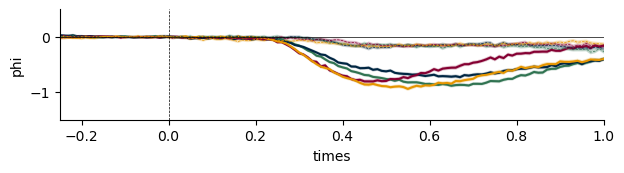

In [280]:
df_all["times"] = df_all["times"].round(2)
cm = 1 / 2.54
emotions = cond_dict["emotion"].values()

fig, ax = plt.subplots(figsize=(16.4587 * cm, 5.5 * cm))
out = df_all.groupby(["times", "emotion"])["phi"].mean().to_numpy()
sns.lineplot(
    x="times",
    y="phi",
    hue="emotion",
    data=df_all,
    ax=ax,
    errorbar="se",
    palette={emo: colors.COLDICT[emo] for emo in emotions},
)
sns.lineplot(
    x="times",
    y="theta",
    hue="emotion",
    data=df_all,
    ax=ax,
    errorbar="se",
    palette={emo: colors.COLDICT[emo] for emo in emotions},
    linestyle="--",
    linewidth=0.5,
    dashes=(14, 14),
)
ax.set_xlim(-0.25, 1.0)
ax.set_ylim(-1.5, 0.5)
plt.axvline(0, color="k", linestyle="--", linewidth=0.5)
plt.axhline(0, color="k", linestyle="-", linewidth=0.5)
plt.tight_layout()
# remove right and top spines
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
# dont show the legend
ax.get_legend().remove()
# save as pdf
fpath = Path(paths.FIGURES, "ET")
fname = Path(fpath, "ET-phi-theta.pdf")
matplotlib.rcParams["pdf.fonttype"] = 42
matplotlib.rcParams["ps.fonttype"] = 42
matplotlib.rcParams["font.family"] = "Roboto"
plt.savefig(fname, dpi=300, bbox_inches="tight", transparent=True)

In [252]:
cond_dict
list(cond_dict["avatar_id"].values())[1]

'Woman_04'

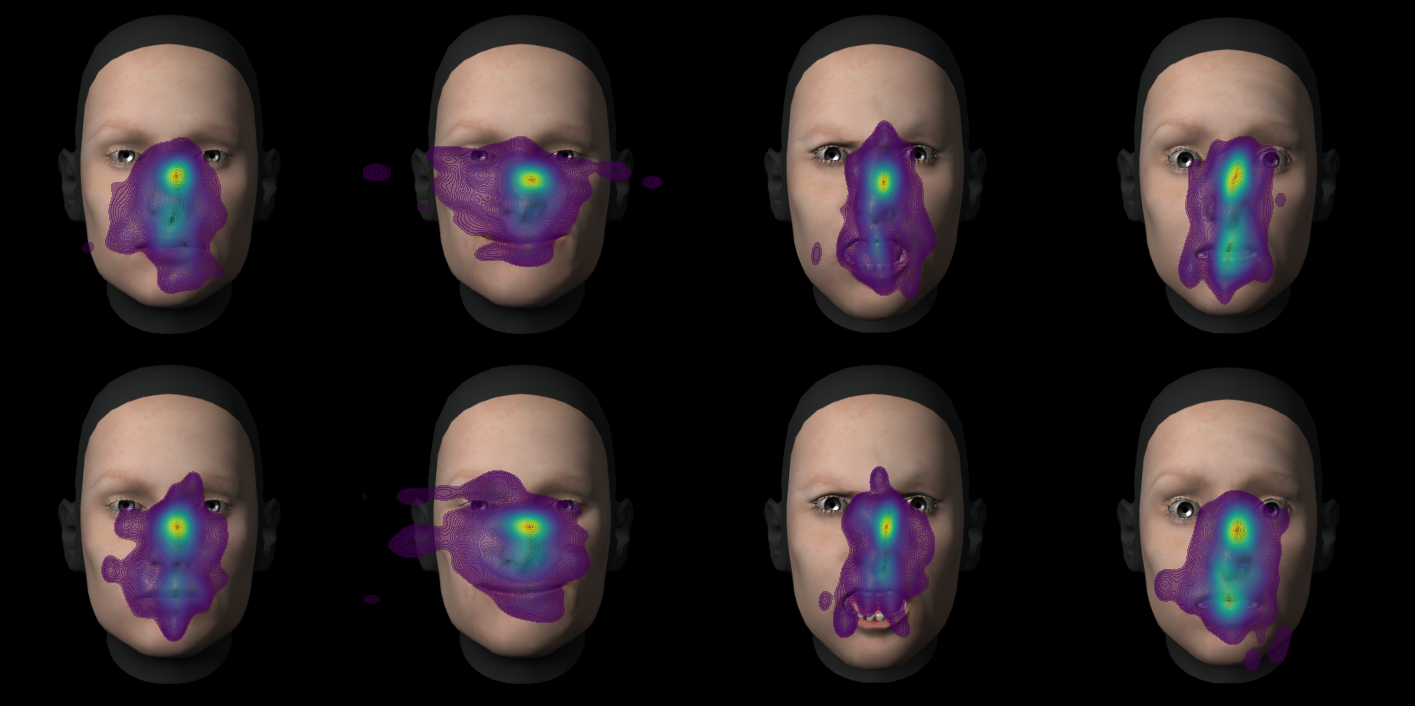

In [339]:
img = plt.imread("Woman_08_Angry.png")
im2 = img[245:-245, 245:-245, :]
height, width, _ = im2.shape

# fig, axs = plt.subplots(3, 4*2, figsize=(12*4/3*2, 12))
fig, axs = plt.subplots(2, 4, figsize=(18, 9))
# set the figure background to black
fig.patch.set_facecolor("black")
fig.patch.set_alpha(1.0)
# set the axes background to black
for ax in axs.flatten():
    ax.patch.set_facecolor("black")
    ax.patch.set_alpha(1.0)
# reduce the space between the subplots
fig.subplots_adjust(hspace=0.02, wspace=0.05)

for vc_idx, viewcond in enumerate(cond_dict["viewcond"].values()):
    for av_idx, av_name in enumerate(list(cond_dict["avatar_id"].values())[1:2]):
        for emo_idx, emotion in enumerate(cond_dict["emotion"].values()):
            # ax = axs[av_idx, emo_idx + vc_idx*4]
            ax = axs[vc_idx, emo_idx]
            data_plot = (
                df_all.query("times > 0.25 & times < 1")
                .query("emotion == @emotion")
                .query("avatar_id == @av_name")
                .query("viewcond == @viewcond")
                .query("sub_id == 'VR2FEM_S10'")
            )
            sns.kdeplot(
                data=data_plot,
                x="theta",
                y="phi",
                fill=True,
                cmap="viridis",
                levels=100,
                thresh=0.05,
                alpha=0.45,
                ax=ax,
            )  # ,
            # sns.scatterplot(data = data_plot, x='theta', y='phi', hue='times', palette='viridis')

            img = plt.imread(f"{av_name}_{emotion.capitalize()}.png")
            cutval = 205
            im2 = img[cutval + 35 : -cutval, cutval + 35 : -cutval, :]
            height, width, _ = im2.shape
            # Overlay the image onto the plot, centered on the axes
            ax.imshow(im2, extent=[-5, 5, -5, 5], alpha=1)
            # hide the axes and the ticks and labels
            ax.axis("off")

# save as pdf
fpath = Path(paths.FIGURES, "ET")
plt.savefig(Path(fpath, "Heatmaps_VR2FEM_S10.pdf"), dpi=300, bbox_inches="tight", pad_inches=0)


# plt.imshow(im2, aspect='auto', alpha=0.5)

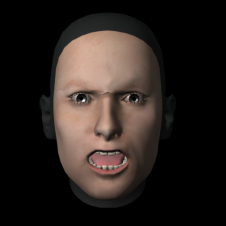

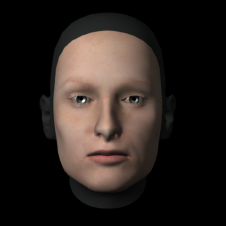

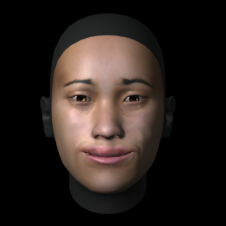

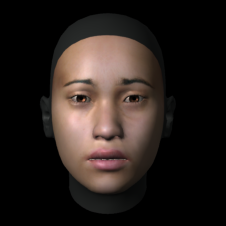

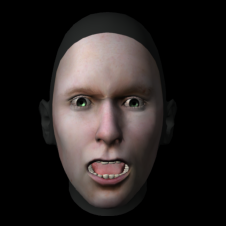

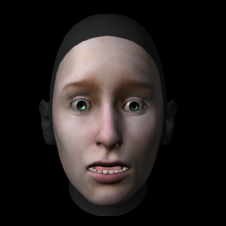

In [358]:
av_names = (
    cond_dict["avatar_id"][2],
    cond_dict["avatar_id"][2],
    cond_dict["avatar_id"][1],
    cond_dict["avatar_id"][1],
    cond_dict["avatar_id"][3],
    cond_dict["avatar_id"][3],
)
emotions = ("angry", "neutral", "happy", "neutral", "angry", "surprised")

for av_name, emotion in zip(av_names, emotions, strict=False):
    fig, ax = plt.subplots(1, figsize=(6 * cm, 6 * cm))

    img = plt.imread(f"{av_name}_{emotion.capitalize()}.png")
    cutval = 205
    im2 = img[cutval + 35 : -cutval, cutval + 35 : -cutval, :]
    height, width, _ = im2.shape
    # Overlay the image onto the plot, centered on the axes
    ax.imshow(im2, alpha=1, aspect="auto")
    # hide the axes and the ticks and labels
    ax.axis("off")
    # remove the white space around the image
    plt.tight_layout()
    # set background to transparent
    fig.patch.set_facecolor("black")
    fig.patch.set_alpha(1.0)
    ax.patch.set_facecolor("black")
    ax.patch.set_alpha(1.0)
    # save as pdf
    fpath = Path(paths.FIGURES)
    fname = Path(fpath, f"{av_name}_{emotion.capitalize()}.pdf")
    plt.savefig(
        fname,
        dpi=300,
        # bbox_inches='tight',
        pad_inches=0,
        transparent=True,
    )

In [159]:
# %% load libs:
import json
import multiprocessing as mp
import sys
from collections import defaultdict
from os import path as op

import mne
import numpy as np
import seaborn as sns

# from mne.epochs import concatenate_epochs
from mne.decoding import GeneralizingEstimator, LinearModel, SlidingEstimator, cross_val_multiscore, get_coef
from scipy import stats
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import BaseCrossValidator, StratifiedKFold, check_cv
from sklearn.pipeline import make_pipeline


def decode_core(X, y, groups, scoring="roc_auc", temp_gen=False, n_cv_folds=5, cv_random_state=None):
    clf = make_pipeline(
        mne.decoding.Vectorizer(), LinearModel(LogisticRegression(solver="liblinear", random_state=42, verbose=False))
    )

    if temp_gen:
        gen_str = "gen_temp"
        se = GeneralizingEstimator(clf, scoring=scoring, n_jobs=15, verbose=0)
    else:
        gen_str = ""
        se = SlidingEstimator(clf, scoring=scoring, n_jobs=15, verbose=0)
    if groups is None:
        cv = StratifiedKFold(n_splits=n_cv_folds)
    else:
        cv = CrossDecodSplitter(n_splits=n_cv_folds)
    scores = cross_val_multiscore(se, X, y, cv=cv, groups=groups, n_jobs=n_cv_folds)

    se.fit(X, y)
    patterns = get_coef(se, "patterns_", inverse_transform=True)

    return scores, patterns

In [ ]:
# select only columns phi and theta
df_s = df_all[["times", "theta", "phi", "viewcond", "avatar_id", "emotion", "sub_id", "trial_num"]]

# scores_all = defaultdict(list)

for sub_id in sub_list_str_et:
    df_ = df_s.query("sub_id == @sub_id")

    # add an index which counts from 0 up, for each trial_num
    df_["times_idx"] = df_.groupby("trial_num").cumcount()
    iidx = pd.MultiIndex.from_product(
        [df_["trial_num"].unique(), df_["times_idx"].unique()],
        names=["trial_num", "times_idx"],
    )
    df_p = pd.pivot_table(df_, values=["phi", "theta"], index=["trial_num", "times_idx"]).reindex(iidx)

    df_p["phi"] = df_p["phi"].interpolate(method="linear")
    df_p["theta"] = df_p["theta"].interpolate(method="linear")
    X = df_p.to_numpy().reshape(df_["trial_num"].nunique(), df_["times_idx"].nunique(), 2).swapaxes(1, 2)

    y = df_.query("times_idx == 0")["emotion"].to_numpy()

    times = df_.groupby("times_idx").mean()["times"].to_numpy()
    sc, pat = decode_core(
        X,
        y,
        groups=None,
        temp_gen=False,
        n_cv_folds=5,
        scoring="roc_auc_ovr",
    )
    scores_all["allemos"].append(sc)

In [242]:
scores_all_arr = np.array(scores_all["allemos"])
sca = scores_all_arr.mean(axis=1)

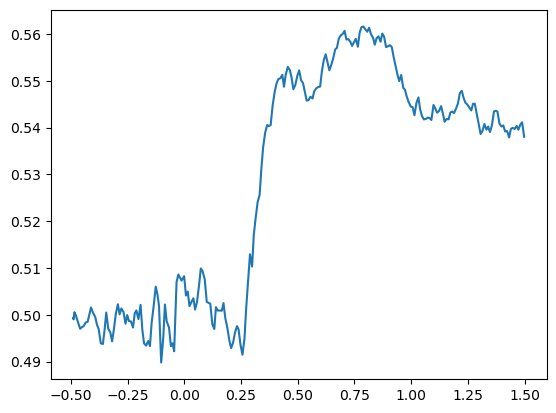

In [243]:
plt.plot(times, sca)

In [326]:
# select only columns phi and theta
df_s = df_all[["times", "theta", "phi", "viewcond", "avatar_id", "emotion", "sub_id", "trial_num"]]


def decode_et(df, sub_id, factor, contrast, scoring, reps=50):
    df_ = df.query("sub_id == @sub_id").query(f"{factor} in @contrast")

    # add an index which counts from 0 up, for each trial_num
    df_["times_idx"] = df_.groupby("trial_num").cumcount()
    iidx = pd.MultiIndex.from_product(
        [df_["trial_num"].unique(), df_["times_idx"].unique()],
        names=["trial_num", "times_idx"],
    )
    df_p = pd.pivot_table(df_, values=["phi", "theta"], index=["trial_num", "times_idx"]).reindex(iidx)
    df_p["phi"] = df_p["phi"].interpolate(method="linear")
    df_p["theta"] = df_p["theta"].interpolate(method="linear")

    # throw away trials which still contain nan values
    times = df_.groupby("times_idx").mean()["times"].to_numpy()
    idx_na = df_p.groupby("trial_num")["phi"].apply(lambda x: x.isna().sum() > 0).to_numpy()
    df_p = df_p[~np.repeat(idx_na, len(times))]

    X = (
        df_p.to_numpy()
        .reshape(df_p.reset_index()["trial_num"].nunique(), df_p.reset_index()["times_idx"].nunique(), 2)
        .swapaxes(1, 2)
    )

    y = df_.query("times_idx == 0")["emotion"].to_numpy()
    y = y[~idx_na]
    sc_tmp = []
    for i in range(reps):
        sc, _ = decode_core(X, y, groups=None, temp_gen=False, n_cv_folds=5, scoring=scoring)
        sc_tmp.append(sc)
    sc = np.array(sc_tmp).mean(axis=0)
    return sc, times

In [336]:
from functools import partial

df_s = df_all[["times", "theta", "phi", "viewcond", "avatar_id", "emotion", "sub_id", "trial_num"]]

factor = "emotion"
scoring = "roc_auc_ovr"

scores_all = defaultdict(list)
times_all = defaultdict(list)
pats_all = defaultdict(list)

save_scores = True

for contrast in [
    ("surprised", "neutral", "angry", "happy")
]:  # [('angry', 'neutral'), ('happy', 'neutral'), ('angry', 'surprised')]:
    for sub_id in sorted(sub_list_str_et):
        print("Running subject: ", sub_id)
        sc, times = decode_et(df_s, sub_id, factor="emotion", contrast=contrast, scoring=scoring, reps=50)
        scores_all[sub_id].append(sc)
        pats_all[sub_id].append(pat)
        times_all[sub_id].append(times)

        # save shizzle:
        contrast_str = "_vs_".join(contrast)
        conditions_vc = ""

        path_save = Path(
            paths.DATA_04_DECOD_SENSORSPACE,
            "ET",
            conditions_vc,
            contrast_str,
            scoring,
        )

        # save accuracies:
        if save_scores:
            fpath = Path(path_save, "scores")
            fpath.mkdir(exist_ok=True, parents=True)
            fname = Path(fpath, f"{sub_id}-scores_per_sub.npy")
            np.save(fname, sc)
            np.save(str(fname)[:-4] + "__times" + ".npy", times)
            del (fpath, fname)

Running subject:  VR2FEM_S01


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
  0%|          | Fitting SlidingEstimator : 0/241 [00:00<?,       ?it/s]
  0%|          | Fitting SlidingEstimator : 0/241 [00:00<?,       ?it/s]
  0%|          | Fitting SlidingEstimator : 0/241 [00:00<?,       ?it/s]
  0%|          | Fitting SlidingEstimator : 0/241 [00:00<?,       ?it/s]
  0%|          | Fitting SlidingEstimator : 0/241 [00:00<?,       ?it/s]
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:   21.3s remaining:   32.0s


ValueError: This solver needs samples of at least 2 classes in the data, but the data contains only one class: 'surprised'

In [334]:
scores_all_4m = scores_all.copy()

In [325]:
scores = defaultdict(dict)
scores[contrast_str] = scores_all

In [ ]:
for sub_id in sorted(sub_list_str_et):
    df_ = df_s.query("sub_id == @sub_id").query("emotion == 'angry' | emotion == 'neutral'")

    # add an index which counts from 0 up, for each trial_num
    df_["times_idx"] = df_.groupby("trial_num").cumcount()
    iidx = pd.MultiIndex.from_product(
        [df_["trial_num"].unique(), df_["times_idx"].unique()],
        names=["trial_num", "times_idx"],
    )
    df_p = pd.pivot_table(df_, values=["phi", "theta"], index=["trial_num", "times_idx"]).reindex(iidx)
    df_p["phi"] = df_p["phi"].interpolate(method="linear")
    df_p["theta"] = df_p["theta"].interpolate(method="linear")

    # throw away trials which still contain nan values
    idx_na = df_p.groupby("trial_num")["phi"].apply(lambda x: x.isna().sum() > 0).to_numpy()
    df_p = df_p[~np.repeat(idx_na, len(times))]

    X = (
        df_p.to_numpy()
        .reshape(df_p.reset_index()["trial_num"].nunique(), df_p.reset_index()["times_idx"].nunique(), 2)
        .swapaxes(1, 2)
    )

    y = df_.query("times_idx == 0")["emotion"].to_numpy()
    y = y[~idx_na]
    times = df_.groupby("times_idx").mean()["times"].to_numpy()
    sc, pat = decode_core(X, y, groups=None, temp_gen=False, n_cv_folds=5, scoring="roc_auc")
    scores_all["angry_vs_neutral"].append(sc)

In [220]:
happy_vs_neutral = np.array(scores_all["happy_vs_neutral"]).mean(axis=0).mean(axis=0)

In [205]:
angry_vs_surprised = np.array(scores_all["angry_vs_surprised"]).mean(axis=0).mean(axis=0)
angry_vs_neutral = np.array(scores_all["angry_vs_neutral"]).mean(axis=0).mean(axis=0)

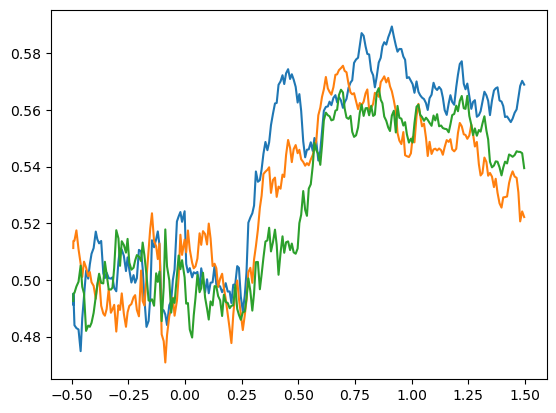

In [206]:
plt.plot(times, pltme)
plt.plot(times, hap_vs_neut)
plt.plot(times, angry_vs_surprised)

In [244]:
df2plot = pd.DataFrame()
for contrast in ["allemos", "angry_vs_surprised", "angry_vs_neutral", "happy_vs_neutral"]:
    vals = np.array(scores_all[contrast]).mean(axis=1).flatten()
    ttimes = np.tile(times, 16)
    ids = np.repeat(np.arange(16), len(times))
    plt_df = pd.DataFrame({"times": ttimes, "vals": vals, "ids": ids})
    plt_df["contrast"] = contrast
    df2plot = pd.concat([df2plot, plt_df])

<AxesSubplot:xlabel='times', ylabel='vals'>

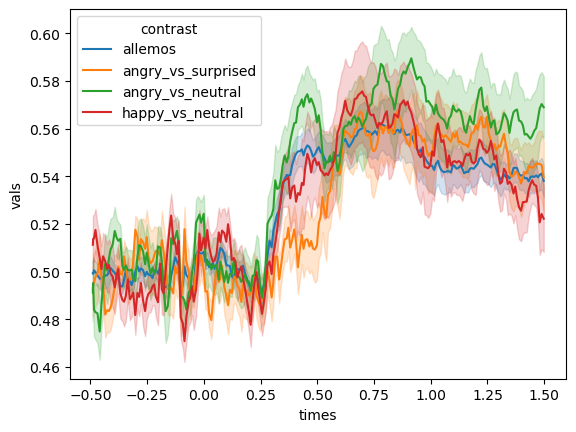

In [245]:
sns.lineplot(data=df2plot, x="times", y="vals", hue="contrast", errorbar="se")

In [224]:
ttimes.shape

(3856,)

In [226]:
vals.shape

(7712,)

In [234]:
contrast = "angry_vs_neutral"
np.array(scores_all[contrast]).shape

(32, 5, 241)

In [230]:
scores_all.keys()

dict_keys(['angry_vs_neutral', 'happy_vs_neutral', 'angry_vs_surprised'])

In [237]:
scores_all["angry_vs_neutral"] = scores_all["angry_vs_neutral"][:16]

In [236]:
scores_all["angry_vs_neutral"][16]

array([[0.52489331, 0.51920341, 0.5398293 , ..., 0.5512091 , 0.51209104,
        0.50426743],
       [0.48719772, 0.5       , 0.48435277, ..., 0.6173542 , 0.61948791,
        0.58819346],
       [0.51789627, 0.52227904, 0.53688824, ..., 0.59751644, 0.60628196,
        0.59897736],
       [0.51497443, 0.52520088, 0.51205259, ..., 0.6055515 , 0.60628196,
        0.59021183],
       [0.61577794, 0.58875091, 0.55076698, ..., 0.54054054, 0.5339664 ,
        0.5266618 ]])